In [1]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import tqdm
from huggingface_hub import notebook_login
import matplotlib.pyplot as plt
from collections import Counter
from tokenizers import Tokenizer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
import random

# Dataset

In [ ]:
dataset = load_dataset('billsum')

In [3]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 18949
    })
    test: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 3269
    })
    ca_test: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 1237
    })
})


In [4]:
print("Text")
print("-"*50)
print(dataset['train']['text'][0])
print("summary")
print("-"*50)
print(dataset['train']['summary'][0])

Text
--------------------------------------------------
SECTION 1. LIABILITY OF BUSINESS ENTITIES PROVIDING USE OF FACILITIES 
              TO NONPROFIT ORGANIZATIONS.

    (a) Definitions.--In this section:
            (1) Business entity.--The term ``business entity'' means a 
        firm, corporation, association, partnership, consortium, joint 
        venture, or other form of enterprise.
            (2) Facility.--The term ``facility'' means any real 
        property, including any building, improvement, or appurtenance.
            (3) Gross negligence.--The term ``gross negligence'' means 
        voluntary and conscious conduct by a person with knowledge (at 
        the time of the conduct) that the conduct is likely to be 
        harmful to the health or well-being of another person.
            (4) Intentional misconduct.--The term ``intentional 
        misconduct'' means conduct by a person with knowledge (at the 
        time of the conduct) that the conduct is harmf

## Tokenization

In [5]:
corpus = dataset['train']['text'] + dataset['train']['summary']

### Build Tokenizer

In [6]:
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()

trainer = BpeTrainer(vocab_size=16000, special_tokens=["[UNK]", "[PAD]", "<EOS>", "<SOS>"])

tokenizer.train_from_iterator(corpus, trainer)

In [7]:
vocab = tokenizer.get_vocab()

In [8]:
vocab_size = len(vocab)
print(vocab_size)

16000


In [9]:
special_tokens = ["[UNK]", "[PAD]", "<EOS>", "<SOS>"]

for token in special_tokens:
    token_id = tokenizer.token_to_id(token)
    print(f"{token}: {token_id}")

[UNK]: 0
[PAD]: 1
<EOS>: 2
<SOS>: 3


## Dataset class

In [10]:
class TextSummaryDataset(Dataset):
    def __init__(self, data, tokenizer, max_input_len=1024, max_target_len=256):
        self.data = data
        self.tokenizer = tokenizer
        self.max_input_len = max_input_len
        self.max_target_len = max_target_len

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
    
        input_enc = self.tokenizer.encode(item['text']).ids[:self.max_input_len]
        target_enc = self.tokenizer.encode(item['summary']).ids[:self.max_target_len]
    
        sos_id = self.tokenizer.token_to_id('<SOS>')
        eos_id = self.tokenizer.token_to_id('<EOS>')
    
        target_enc = [sos_id] + target_enc + [eos_id]
    
        return torch.tensor(input_enc), torch.tensor(target_enc), len(input_enc), len(target_enc)
        

### initiate Dataset

In [11]:
train_dataset = TextSummaryDataset(dataset['train'].select(range(10000)), tokenizer)
test_dataset = TextSummaryDataset(dataset['test'], tokenizer)

In [12]:
label_pad_idx = -100

## Dataloader

In [13]:
def collate_fn(batch):
    input_ids, labels, lengths_list, out_lengths = zip(*batch)

    lengths = torch.tensor(lengths_list)
    out_lengths = torch.tensor(out_lengths)
    
    lengths, idx = lengths.sort(descending=True)
    input_ids = [input_ids[i] for i in idx]
    labels = [labels[i] for i in idx]

    padded_inputs = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.token_to_id('[PAD]'))
    padded_labels = pad_sequence(labels, batch_first=True, padding_value=label_pad_idx)  

    return padded_inputs, padded_labels, lengths, out_lengths

In [14]:
train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

# Model

In [15]:
class Encoder(nn.Module):
    def __init__(self, embedd_dim, vocab_size, hidden_dim, num_layers, bidirectional, dropout, pad_indx):
        super().__init__()
        self.bidirectional = bidirectional
        self.num_layers = num_layers
        self.embd = nn.Embedding(vocab_size, embedd_dim, pad_indx)
        self.lstm = nn.LSTM(input_size=embedd_dim, hidden_size=hidden_dim, 
                            num_layers=num_layers, bidirectional=bidirectional, 
                            dropout=dropout, batch_first=True)
        
    def forward(self, text, lengths):
        embed = self.embd(text)
        packed_input = pack_padded_sequence(embed, lengths, batch_first=True)
        packed_output, (hidden, cell) = self.lstm(packed_input) 
        if self.bidirectional:
            hidden, cell = torch.cat((hidden[0: self.num_layers], hidden[self.num_layers:]), dim=2), torch.cat((cell[0: self.num_layers], cell[self.num_layers:]), dim=2)
        return hidden, cell

In [16]:
class Decoder(nn.Module):
    def __init__(self, embedd_dim, vocab_size, enc_dim, num_layers, dropout, pad_indx):
        super().__init__()
        self.embd = nn.Embedding(vocab_size, embedd_dim, pad_indx)
        self.lstm = nn.LSTM(input_size=embedd_dim, hidden_size=enc_dim, 
                            num_layers=num_layers, 
                            dropout=dropout, batch_first=True)
        self.fc = nn.Linear(enc_dim, vocab_size)
        
    def forward(self, text, hidden, cell):
        embed = self.embd(text)
        output, (hidden, cell) = self.lstm(embed, (hidden, cell)) 
        output = self.fc(output)
        return output, hidden, cell

In [17]:
class Summarizer(nn.Module):
    def __init__(self, embedd_dim, vocab_size, hidden_dim, num_layers, bidirectional, dropout, pad_indx):
        super().__init__()
        self.encoder = Encoder(embedd_dim, vocab_size, hidden_dim, num_layers, bidirectional, dropout, pad_indx)
        self.enc_dim = 2 * hidden_dim if bidirectional else hidden_dim
        self.decoder = Decoder(embedd_dim, vocab_size, self.enc_dim, num_layers, dropout, pad_indx)
        self.vocab_size = vocab_size
        
    def forward(self, text, summary, lengths):
        batch_size, tgt_len = summary.shape
        outputs = torch.zeros((batch_size, tgt_len, self.vocab_size), device=text.device)
        
        hidden, cell = self.encoder(text, lengths)
        input_token = summary[:, 0].unsqueeze(1)

        for t in range(1, tgt_len):
            output, hidden, cell = self.decoder(input_token, hidden, cell)
            outputs[:, t, :] = output.squeeze(1)
            input_token = output.argmax(2)

        return outputs

# Training Loop

In [18]:
def training_loop(model, dataloader, optimizer, criterion, epochs, device, label_pad_idx):
    model.train()
    losses = []
    accuracies = []

    for epoch in range(epochs):
        running_loss = 0.0
        total_correct = 0
        total_tokens = 0

        progress_bar = tqdm.tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}")

        for inputs, labels, lengths, lengths_label in progress_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            lengths = lengths.to("cpu") 

            optimizer.zero_grad()

            outputs = model(inputs, labels, lengths) 

            target = labels[:, 1:]  
            output = outputs[:, 1:]

            loss = criterion(output.contiguous().view(-1, output.shape[-1]), target.contiguous().view(-1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * target.numel()

            preds = torch.argmax(output, dim=2)
            mask = target != label_pad_idx
            total_correct += ((preds == target) & mask).sum().item()
            total_tokens += mask.sum().item()

            avg_batch_loss = running_loss / total_tokens
            batch_accuracy = total_correct / total_tokens
            progress_bar.set_postfix(loss=f"{avg_batch_loss:.4f}", acc=f"{batch_accuracy:.4f}")

        epoch_loss = running_loss / total_tokens
        epoch_accuracy = total_correct / total_tokens
        losses.append(epoch_loss)
        accuracies.append(epoch_accuracy)

    return losses, accuracies

# Training

In [19]:
embedd_dim = 500
hidden_dim = 128
num_layers = 2
bidirectional = True
dropout = 0.5
pad_indx = tokenizer.token_to_id('[PAD]')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
summarizer = Summarizer(embedd_dim, vocab_size, hidden_dim, num_layers, bidirectional, dropout, pad_indx).to(device)
optimizer = torch.optim.Adam(summarizer.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=label_pad_idx)
epochs = 10

In [ ]:
losses, accuracies =  training_loop(summarizer, train_loader, optimizer, criterion, epochs, device, label_pad_idx)

# Inference

In [28]:
def inference_loop(model, data_loader, tokenizer, device, max_examples=2):
    model.eval()
    examples_shown = 0
    total_correct = 0
    total_tokens = 0

    with torch.inference_mode():
        for inputs, labels, lengths, lengths_label in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs, labels, lengths)

            target = labels[:, 1:]  # Assuming <SOS> at position 0
            output = outputs[:, 1:]

            preds = torch.argmax(output, dim=2)
            mask = target != label_pad_idx
            total_correct += ((preds == target) & mask).sum().item()
            total_tokens += mask.sum().item()

            if examples_shown < max_examples:
                for i in range(len(labels)):
                    pred_ids = preds[i]
                    true_ids = target[i]  # skip <SOS>

                    # Filter out padding (-100)
                    pred_filtered = pred_ids[true_ids != label_pad_idx].tolist()
                    true_filtered = true_ids[true_ids != label_pad_idx].tolist()

                    print(f"[Example {examples_shown + 1}]")
                    print("Prediction   :", tokenizer.decode(pred_filtered))
                    print("Ground Truth :", tokenizer.decode(true_filtered))
                    print("-" * 40)

                    examples_shown += 1
                    if examples_shown >= max_examples:
                        break

    accuracy = total_correct / total_tokens if total_tokens > 0 else 0
    print(f"Inference Accuracy: {accuracy * 100:.2f}%")

    return accuracy

In [29]:
inference_loop(summarizer, test_loader, tokenizer, device)

[Example 1]
Prediction   : National Land Land Act Act of 1993 - Directs the Secretary of the to to the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Ground Truth : Federal For age Fee Act of 1993 - Subjects grazing operations on Federal land to applicable Federal , State , and local environmental and land use requirements . Sets forth a for age fee formula for lands under the jurisdiction of the Department of Agriculture and the Department of the Interior .
----------------------------------------
[Example 2]
Prediction   : Amends the Internal of Code to allow a 1 of the of the of the the of the of the of the of the of the of the of the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the t

0.07469489982565704

# Result

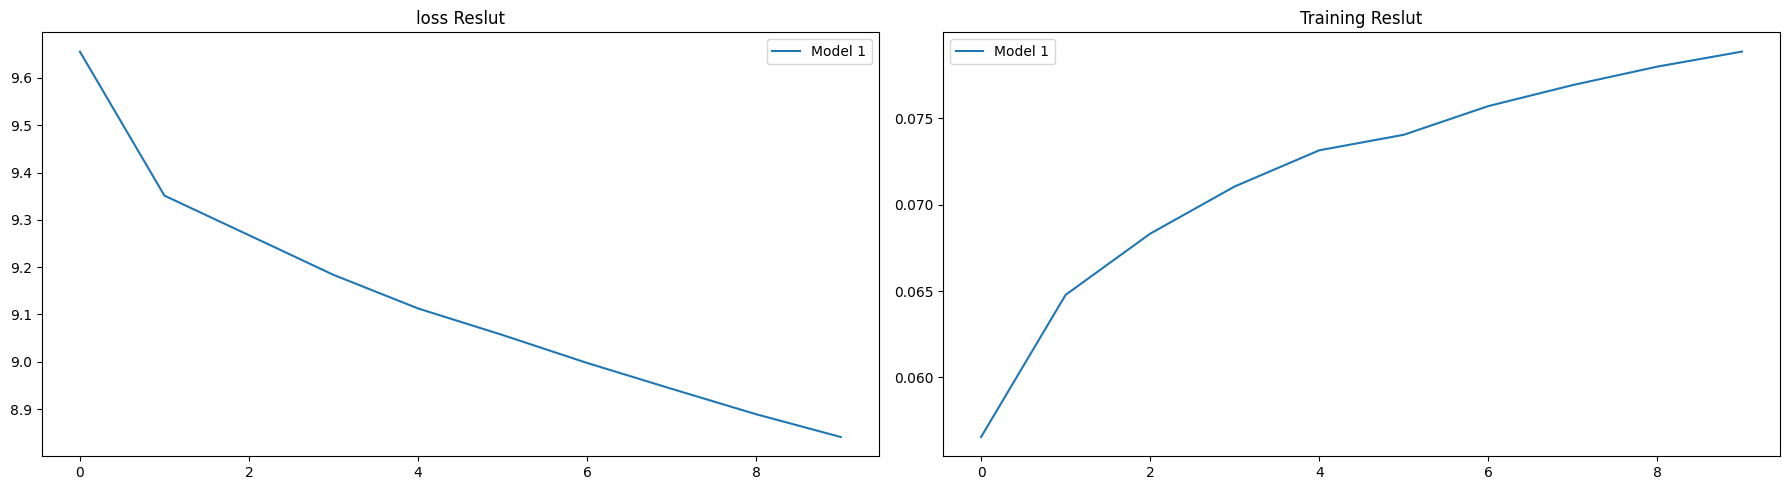

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
ax[0].plot(losses)
ax[0].set_title("loss Reslut")
ax[0].legend(['Model 1', 'Model 2', 'Model 3', 'Model 4'])

ax[1].plot(accuracies)
ax[1].set_title("Training Reslut")
ax[1].legend(['Model 1', 'Model 2', 'Model 3', 'Model 4'])

plt.tight_layout()
plt.show()